In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime

#Neural Nets
import tensorflow as tf

# Add the parent directory to the Python path to allow imports from tests/
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from tests.data_eng import get_raw_data, get_selected_stocks
from dotenv import load_dotenv

from mkt_data_ETL.data_load_and_transform import get_data, get_top_mkt_cap_stocks


import warnings

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Get data 
#sp500_comp, spx_index, sp500_stock_data = get_raw_data()
#top_100_mkt_cap_df, top_100_mkt_cap_prices_df = get_selected_stocks(sp500_stock_data)

In [3]:
stock_prices_df, stock_shares_amount_df, mkt_cap_df, spx_index, removed_companies = get_data()

Fail processing CA: 'str' object has no attribute 'keys'
Fail processing EMC: 'str' object has no attribute 'keys'
Fail processing SHLD: 'str' object has no attribute 'keys'


In [4]:
top_100_mkt_cap_df, top_100_mkt_cap_prices_df=get_top_mkt_cap_stocks(stock_prices_df=stock_prices_df, 
stock_mkt_cap_df=mkt_cap_df)

In [5]:
#Cálculo dos pesos dos portfolios 

# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))


mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

#DWP portfolio
p = 0.5
power_p_transform = mkt_portfolio_weights.apply(lambda mu: mu**p,axis=0 )
dwp_portfolio_weights = power_p_transform.div(power_p_transform.sum(axis=1),axis=0 )


# Calculo dos retornos dos portfolios
# O shift nos pesos considera que as compras das ações com os pesos calculados em D0 
# sejam efetuadas no final do dia, recebendo assim o retorno das ações no fechamento do dia seguinte

#Retorno do portfólio de mercado
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

# Retorno do Portfólio DWP
dwp_return = (dwp_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)


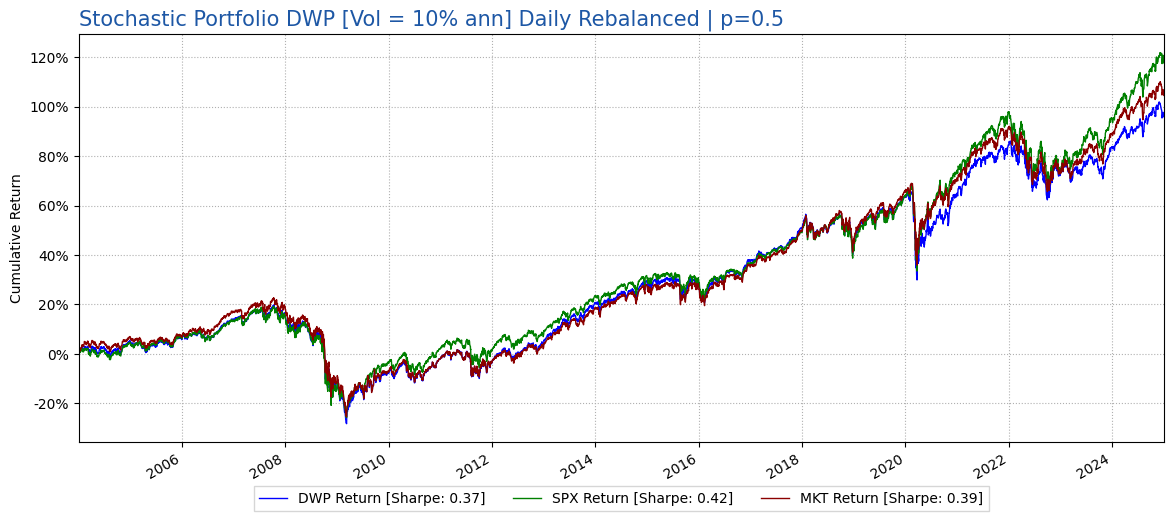

In [6]:
# Normalize every strategy to 10% ann vol (ex-post)
def plot_cumulative_returns(series_dict, p_value, target_vol=0.1):
    """
    Plot cumulative returns for multiple series normalized to target volatility.
    
    Parameters:
    -----------
    series_dict : dict
        Dictionary with series names as keys and pandas Series as values
    p_value : float
        DWP portfolio parameter p
    target_vol : float, optional
        Target annualized volatility (default: 0.1 for 10%)
    """
    # Normalize series to target volatility
    normalized_series = {}
    sharpe_ratios = {}
    
    for name, series in series_dict.items():
        # Calculate volatility scaler
        vol_scaler = target_vol / series.std() / np.sqrt(252)
        normalized_series[name] = series * vol_scaler
        
        # Calculate Sharpe ratio
        sharpe_ratios[name] = np.sqrt(252) * normalized_series[name].mean() / normalized_series[name].std()
    
    # Create plot
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,1,1)
    
    # Plot each series
    colors = {'dwp': 'blue', 'spx': 'green', 'mkt': 'darkred'}
    for name, series in normalized_series.items():
        label = f'{name.upper()} Return [Sharpe: {sharpe_ratios[name]:.2f}]'
        ((series+1).cumprod()-1).plot(label=label, linewidth=1.0, color=colors.get(name, 'gray'))
    
    # Format plot
    plt.grid(linestyle=':')
    ax.margins(x=0)
    ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
    ax.set_xlabel(None)
    ax.set_ylabel('Cumulative Return')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=False, shadow=False, ncol=3)
    plt.title(f'Stochastic Portfolio DWP [Vol = {target_vol:.0%} ann] Daily Rebalanced | p={p_value}', 
              loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
    plt.show()


series_dict = {
    'dwp': dwp_return,
    'spx': sp500_idx_returns['SP500'].reindex(mkt_return.index),
    'mkt': mkt_return
}
plot_cumulative_returns(series_dict, p)

In [7]:
##################################################
# # MONTAGEM DAS AMOSTRAS DE TREINO E DE TESTE # #
##################################################


# Copiando os dados gerados anteriormente 
# Pesos do Portfolio de mercado
mu_t_df = mkt_portfolio_weights.copy()

# Retorno das ações
R_t_df =  stocks_returns.copy()

#Retorno do portfólio de mercado
#Iloc[1:] para iniciar as series em 2004-01-05 e eliminar os valores NaN decorrentes do calculo do retorno. 
mu                   = tf.convert_to_tensor(mu_t_df.iloc[1:].values, dtype=tf.float32) # Pesos de mercado
mkt_ret              = tf.convert_to_tensor(mkt_return.iloc[1:], dtype=tf.float32)              # Retorno do portfólio de mercado
R_t_df               = tf.convert_to_tensor(R_t_df.iloc[1:].values, dtype=tf.float32)

indices = np.arange(len(mu))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False)

# Split datasets

#Treino
mu_train            = tf.convert_to_tensor(mu.numpy()[train_idx], dtype=tf.float32)
mkt_ret_train       = tf.convert_to_tensor(mkt_ret.numpy()[train_idx] , dtype=tf.float32)
stock_returns_train = tf.gather(R_t_df, train_idx)

# Teste
mu_test            = tf.convert_to_tensor(mu.numpy()[test_idx], dtype=tf.float32)
mkt_ret_test       = tf.convert_to_tensor(mkt_ret.numpy()[test_idx], dtype=tf.float32)
stock_returns_test = tf.gather(R_t_df, test_idx)


# Input da rede
training_input = tf.concat([mu_train, stock_returns_train], axis=1)
test_input     = tf.concat([mu_test,  stock_returns_test], axis=1)

input_dim =  training_input.shape[1] # 200

In [8]:
##################################################
############### DESIGN DA REDE ###################
##################################################

class PINN(tf.keras.Model):
    def __init__(self, input_dim=200):
        """
        Inicializa o modelo PINN com uma arquitetura otimizada para aprender
        funções suaves (C^2) e côncavas.

        Args:
            input_dim (int): A dimensionalidade da entrada da rede (padrão: 200).
        """
        super(PINN, self).__init__()
        
        initializer = tf.keras.initializers.GlorotNormal()
        l2_regularizer = tf.keras.regularizers.l2(0.001)

        # O corpo principal da rede é definido usando tf.keras.Sequential
        # para maior clareza e manutenibilidade.
        self.hidden_layers = tf.keras.Sequential([
            # Camada de Entrada
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            
            # Bloco Oculto 1
            # Usamos 'swish' por ser suave (C^∞) e ter ótimo desempenho.
            # A arquitetura de largura constante (128 neurônios) é robusta.
            tf.keras.layers.Dense(100, activation='swish', kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 2
            tf.keras.layers.Dense(100, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 3
            # tf.keras.layers.Dense(20, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
        ])
        
        # A camada de saída permanece a mesma, pois 'softplus' garante G > 0.
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus')

    def call(self, inputs):
        """
        Executa a passagem para a frente (forward pass).
        A lógica de separação e concatenação foi removida por ser redundante.
        """
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

In [9]:
def custom_loss(model, x, ret, ret_mkt):
    # Precompute D_p and its derivatives analytically
    eps = 1e-8
    sqrt_x = tf.sqrt(x + eps)  # [batch_size, n]
    s = tf.reduce_sum(sqrt_x, axis=1)  # [batch_size]
    D_p = tf.square(s)  # [batch_size]
    
    # Gradient of D_p (analytical)
    inv_sqrt_x = 1.0 / sqrt_x  # [batch_size, n]
    grad_D_p = tf.expand_dims(s, axis=1) * inv_sqrt_x  # [batch_size, n]
    
    # Hessian of D_p (analytical)
    diag_correction = -0.5 * tf.expand_dims(s, axis=1) * tf.pow(x + eps, -1.5)  # [batch_size, n]
    A = 0.5 * tf.expand_dims(inv_sqrt_x, 1) * tf.expand_dims(inv_sqrt_x, 2)  # [batch_size, n, n]
    H_D_p = A + tf.linalg.diag(diag_correction)  # [batch_size, n, n]

    # Compute G and its gradients
    with tf.GradientTape() as tape1:
        tape1.watch(x)
        inputs = tf.concat([x, ret], axis=1)
        G_x_pred = model(inputs)  # [batch_size, 1]
    
    # First-order gradient of G
    grad_G_pred = tape1.gradient(G_x_pred, x)  # [batch_size, n]
    
    # Second-order gradient (Hessian) of G
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        inputs = tf.concat([x, ret], axis=1)
        grad_G_pred_ = model(inputs)  # We'll recompute to avoid persistent tape
    H_G_pred = tape2.batch_jacobian(grad_G_pred_, x)  # [batch_size, n, n]

    #############################################
    #          PERDA MSE DAS FUNÇÕES           #
    #############################################
    loss_func = G_x_pred - tf.expand_dims(D_p, axis=1)
    mse = tf.reduce_mean(tf.square(loss_func))
    
    #############################################
    #          PERDAS DAS HESSIANAS            #
    #############################################
    H_diff = H_G_pred - H_D_p
    hessian_loss = tf.reduce_mean(tf.square(tf.norm(H_diff, ord='fro', axis=[1, 2])))
    
    #############################################
    #          PERDAS DOS GRADIENTES           #
    #############################################
    grad_diff = grad_G_pred - grad_D_p
    gradient_loss = tf.reduce_mean(tf.square(tf.norm(grad_diff, ord='euclidean', axis=1)))
    
    #############################################
    #            PERDA TOTAL                   #
    #############################################
    total_loss = mse + 0.05*gradient_loss + 0.025*hessian_loss

    return total_loss, {
        'excess_return_series': loss_func,
        'grad_log_G_X_norm': tf.norm(grad_G_pred, ord='euclidean', axis=1),
    }

In [10]:
# Prepara o banco de dados  (sem embaralhamento para manter a dependencia tempral das series)
batch_size = 126
dataset = tf.data.Dataset.from_tensor_slices(
    (mu_train, stock_returns_train, mkt_ret_train)
).batch(batch_size)

# Model Compilation
model = PINN(input_dim=200)  # 100 (x) + 100 (r_t) = 200
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01)


###########################################################
## Vetores para armazenamento de métricas de Treinamento ##
###########################################################
avg_epoch_loss_vect = []

grad_norms_per_epoch = {}
excess_of_ret_per_epoch = {}

grad_norms_batch_vect     = []
excess_ret_per_batch_vect = []


# Training loop (batches processed in sequence)
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch, ret_batch, ret_mkt_batch in dataset:
        with tf.GradientTape() as tape:
            loss_value, metrics_dics = custom_loss(model, x_batch, ret_batch, ret_mkt_batch)

        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        grad_norms_batch_vect = grad_norms_batch_vect + metrics_dics['grad_log_G_X_norm'].numpy().tolist()
        excess_ret_per_batch_vect = excess_ret_per_batch_vect + metrics_dics['excess_return_series'].numpy().tolist()

        epoch_loss += loss_value.numpy()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    
    avg_epoch_loss_vect.append(avg_epoch_loss)
    grad_norms_per_epoch[str(epoch)]  = grad_norms_batch_vect
    excess_of_ret_per_epoch[str(epoch)]  = excess_ret_per_batch_vect

    grad_norms_batch_vect     = []
    excess_ret_per_batch_vect = []

    # Print average Epoch loss
    if epoch % 100==0:
        print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

Epoch 0/100, Avg Loss: 1.2768283862237184e+16
Epoch 99/100, Avg Loss: 1.2768283862237184e+16


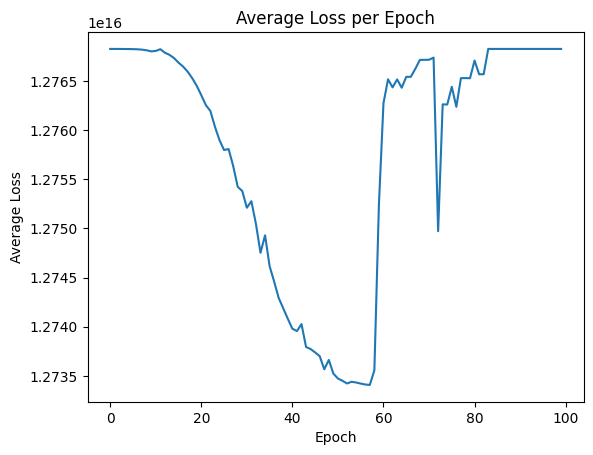

In [11]:
plt.plot(avg_epoch_loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (4722,) and (4755, 1)

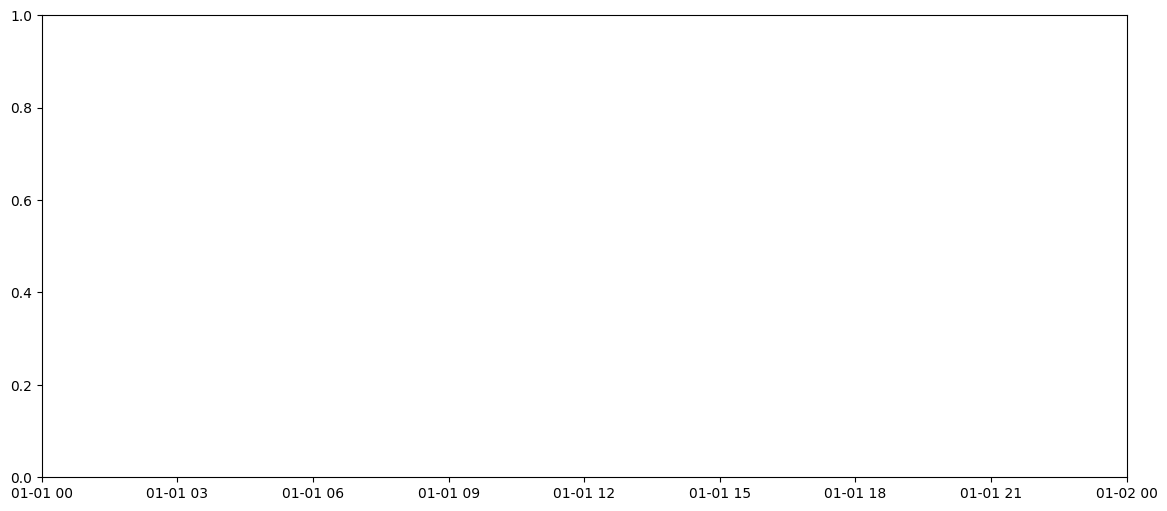

In [12]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(excess_of_ret_per_epoch),50)]+[str(len(excess_of_ret_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, excess_of_ret_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Excess Of return')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Excess of Return Per Epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (4722,) and (4755,)

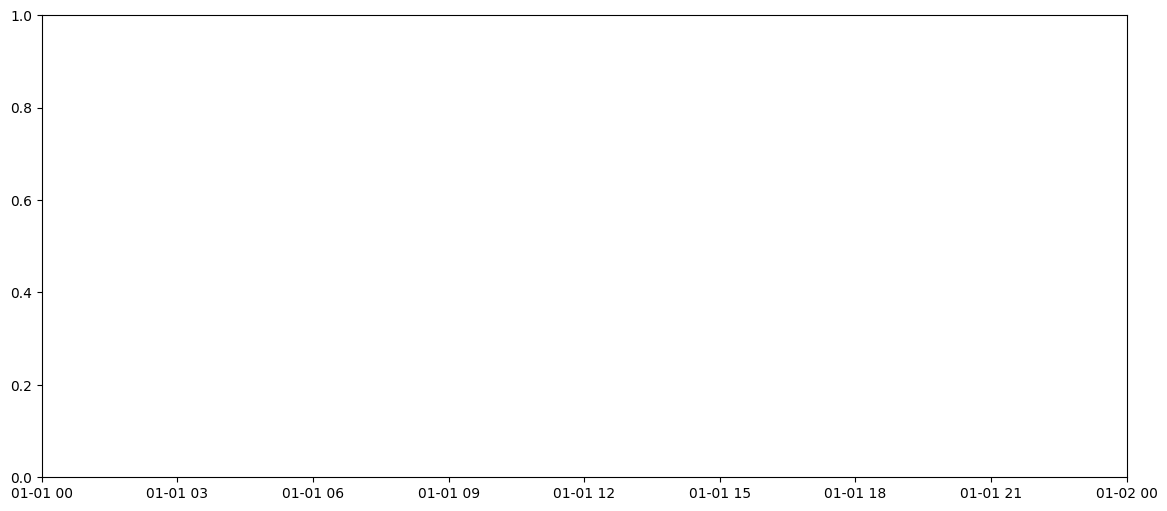

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(grad_norms_per_epoch),50)]+[str(len(grad_norms_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, grad_norms_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
#ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Gradient Norma')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Gradient Norm in per epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

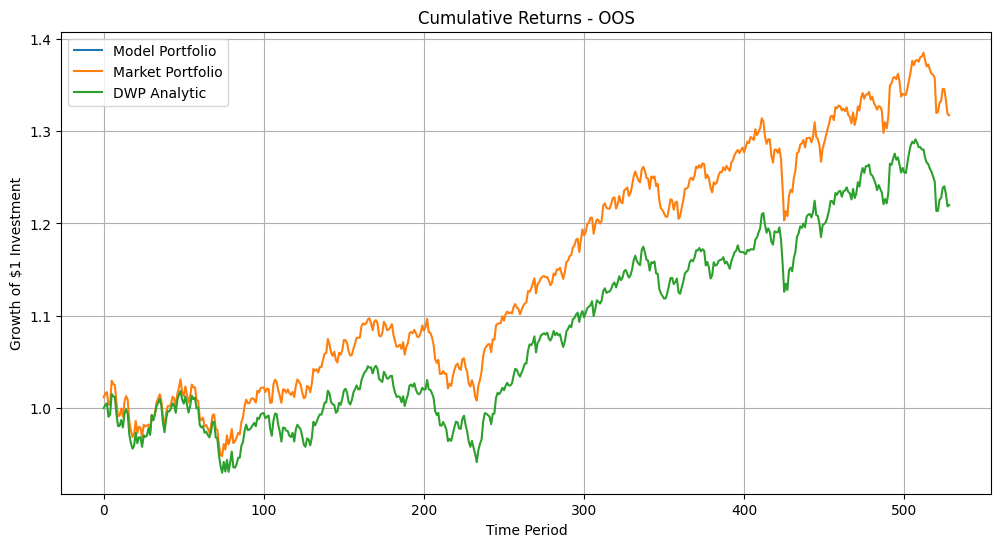

In [ ]:
# ##################################################
# ########### TEST SET EVALUATION ##################
# ##################################################

# # Compute portfolio returns on the test set
with tf.GradientTape() as tape:
    tape.watch(mu_test)
    # Generate predictions in inference mode
    test_inputs = tf.concat([mu_test, stock_returns_test], axis=1)
    G_test = model(test_inputs, training=False)  # Disable dropout/bn training
    log_G_test = tf.math.log(G_test)

# Calculate gradients for portfolio weights
grad_log_G_mu_test = tape.gradient(log_G_test, mu_test)

# Compute portfolio weights (pi_t)
inner_prod_test = tf.reduce_sum(mu_test * grad_log_G_mu_test, axis=1, keepdims=True)
grad_log_G_plus_1_test = grad_log_G_mu_test + 1.0
sum_terms_test = grad_log_G_plus_1_test - inner_prod_test
pi_t_test = sum_terms_test * mu_test

# Calculate portfolio returns
port_ret_test = tf.reduce_sum(pi_t_test * stock_returns_test, axis=1)

# Convert to numpy for analysis
port_ret_test_np = port_ret_test.numpy()
market_ret_test_np = mkt_ret_test.numpy().flatten()  # Market returns

# DWP Cumulative Return - OOS

p = 0.5
transf_p = tf.pow(mu_test, p)
row_sums = tf.reduce_sum(transf_p, axis=1, keepdims=True)
dwp_port_wgt = transf_p / row_sums  # shape (525, 100)
dwp_port_wgt_shifted = tf.concat([tf.zeros((1, tf.shape(dwp_port_wgt)[1])), dwp_port_wgt[:-1]], axis=0)
dwp_R = tf.reduce_sum(dwp_port_wgt_shifted * stock_returns_test, axis=1)  # shape (525,)

# Calculate cumulative returns
cumulative_model = np.cumprod(1 + port_ret_test_np)
cumulative_market = np.cumprod(1 + market_ret_test_np)
cumulative_DWP = tf.math.cumprod(1 + dwp_R)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_model, label="Model Portfolio")
plt.plot(cumulative_market, label="Market Portfolio")
plt.plot(cumulative_DWP.numpy(), label="DWP Analytic")
plt.title("Cumulative Returns - OOS")
plt.xlabel("Time Period")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np

def calcular_g_x_t(df, p):
    return np.power(np.sum(np.pow(df,p),axis=1), 1/p)


G_p = calcular_g_x_t(mu.numpy(), 0.5)

inputs = tf.concat([mu, R_t_df], axis=1)
G_p_nn = model(inputs, training=False)



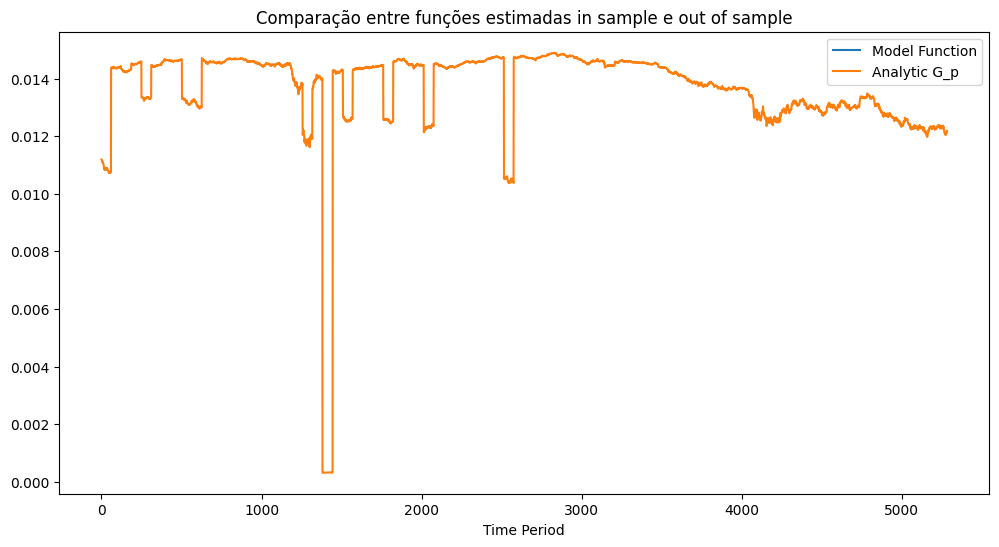

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(G_p_nn.numpy()/(np.sqrt( np.sum(G_p_nn.numpy()**2) )), label="Model Function")
plt.plot(G_p/(np.sqrt( np.sum(G_p**2) )), label="Analytic G_p")
plt.title("Comparação entre funções estimadas in sample e out of sample")
#plt.title("função gerada pela rede")
plt.legend()
plt.xlabel("Time Period")
plt.show()

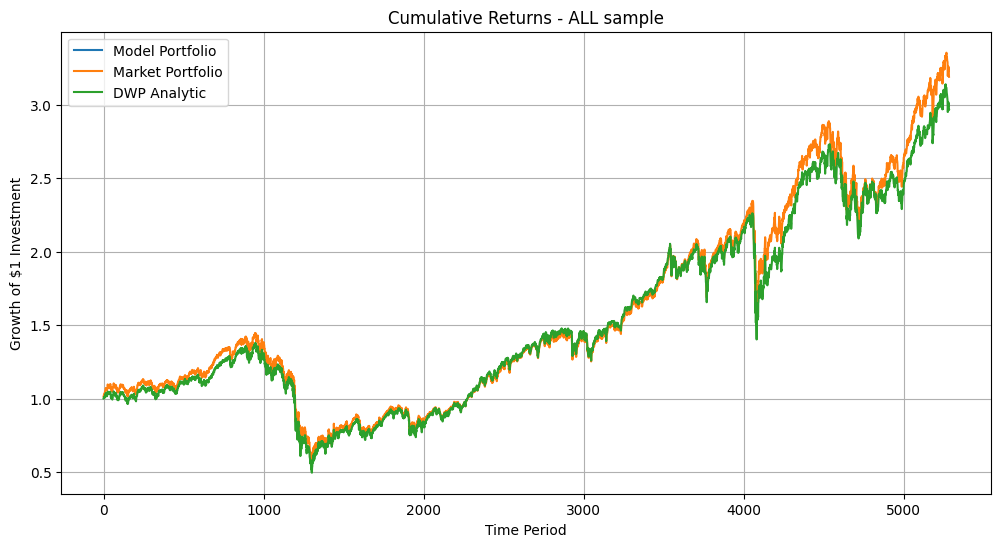

In [ ]:
# ##################################################
# ########### IN SAMPLE ##################
# ##################################################

# # Compute portfolio returns on the test set
with tf.GradientTape() as tape:
    tape.watch(mu)
    # Generate predictions in inference mode
    test_inputs = tf.concat([mu, R_t_df], axis=1)
    G_test = model(test_inputs, training=False)  # Disable dropout/bn training
    log_G = tf.math.log(G_test)

# Calculate gradients for portfolio weights
grad_log_G_mu = tape.gradient(log_G, mu)

# Compute portfolio weights (pi_t)
inner_prod_test = tf.reduce_sum(mu * grad_log_G_mu, axis=1, keepdims=True)
grad_log_G_plus_1_test = grad_log_G_mu + 1.0
sum_terms_test = grad_log_G_plus_1_test - inner_prod_test
pi_t_test = sum_terms_test * mu

# Calculate portfolio returns
port_ret_test = tf.reduce_sum(pi_t_test * R_t_df, axis=1)

# Convert to numpy for analysis
port_ret_test_np = port_ret_test.numpy()
market_ret_test_np = mkt_ret.numpy().flatten()  # Market returns

# DWP Cumulative Return - OOS
p = 0.5
transf_p = tf.pow(mu, p)
row_sums = tf.reduce_sum(transf_p, axis=1, keepdims=True)
dwp_port_wgt = transf_p / row_sums  # shape (525, 100)
dwp_port_wgt_shifted = tf.concat([tf.zeros((1, tf.shape(dwp_port_wgt)[1])), dwp_port_wgt[:-1]], axis=0)
dwp_R = tf.reduce_sum(dwp_port_wgt_shifted * R_t_df, axis=1)  # shape (525,)

# Calculate cumulative returns
cumulative_model = np.cumprod(1 + port_ret_test_np)
cumulative_market = np.cumprod(1 + market_ret_test_np)
cumulative_DWP = tf.math.cumprod(1 + dwp_R)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_model, label="Model Portfolio")
plt.plot(cumulative_market, label="Market Portfolio")
plt.plot(cumulative_DWP.numpy(), label="DWP Analytic")
plt.title("Cumulative Returns - ALL sample")
plt.xlabel("Time Period")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True)
plt.show()


